In [24]:
%matplotlib inline

In [86]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import ee
import geemap
import cartopy 
import cartopy.crs as ccrs
import geemap.colormaps as cm
import folium
import contextily as ctx

from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import Patch, Rectangle
import adjustText as aT
from adjustText import adjust_text
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from geemap import cartoee
from matplotlib import pyplot as plt
from IPython.display import Image

In [4]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AWgavdd4S36G8E6wzFgpR2SOvjtS-6mCNDFQLP4mZMU0MlFYtrkHjN5NEA4



Successfully saved authorization token.


In [5]:
## Lat and lon for center extent
lat = 34.481
lon = -18.862

## Import region of interest from google asset
roi = ee.FeatureCollection ("users/gee07revalue/sofala_province_gorongosa")

In [90]:
## convert roi to dataframe
df_roi = geemap.ee_to_geopandas(roi)
df_roi.head()

,geometry,COUNTRY,GID_2,NAME_1
0,"MULTIPOLYGON (((34.69014 -20.55792, 34.69042 -...",Mozambique,MOZ.9.1_1,Sofala


In [6]:
## Import landsat dataset from google asset
dataset = ee.ImageCollection("users/gee03revalue/sofala-images/sofala-collection")

In [7]:
## Print total images
print("Total Images:",dataset.size().getInfo())

Total Images: 4


In [8]:
## Spectral Indices Function
def defaultIndices (img):
    ndvi  = img.normalizedDifference(['NIR','RED']).rename('NDVI')
    ndmi  = img.normalizedDifference(['NIR','SWIR1']).rename('NDMI')
    bsi   = img.expression('((SWIR1 + RED) - (NIR + BLUE))/((SWIR1 + RED) + (NIR + BLUE))', {
                                                                'NIR'   : img.select('NIR'),
                                                                'RED'   : img.select('RED'),
                                                                'BLUE'  : img.select('BLUE'),
                                                                'SWIR1' : img.select('SWIR1'),
                                                          }).rename('BSI')
    ndwi  = img.normalizedDifference(['GREEN','SWIR1']).rename('NDWI')
    return img.clip(roi).addBands(ndvi).addBands(ndmi).addBands(bsi).addBands(ndwi)

In [9]:
## define visual parameters true color
trueColor = {
                'bands':['RED','GREEN','BLUE'],
                'min':7000,
                'max':18000,
                'dimensions':300,
                'region':roi.geometry()
                }

In [10]:
## define visual parameters false color
falseColor = {
                'bands':['NIR','SWIR1','SWIR2'],
                'min':8000,
                'max':18000,
                'dimensions':300,
                'region':roi.geometry()
                  }

In [11]:
## define visual parameters true color
indices_viz_params = {
            'min': 0,
            'max': 0.5,
            'dimensions':300,
            'region':roi.geometry(),
            'palette': cm.get_palette(cmap_name='viridis')}

In [12]:
## Rename the bands
img_col = dataset.select(dataset.first().bandNames(),['BLUE','GREEN','RED','NIR','SWIR1','SWIR2']).map(defaultIndices)

## Make the collection into list
img_list = img_col.toList(dataset.size())

In [13]:
## Print band Names
print (img_col.first().bandNames().getInfo())

['BLUE', 'GREEN', 'RED', 'NIR', 'SWIR1', 'SWIR2', 'NDVI', 'NDMI', 'BSI', 'NDWI']


In [14]:
# Select ndvi as an example
ndvi_2013 = ee.Image(img_col.first()).select('NDVI')

In [15]:
# Create a URL to the styled image for a region around France.
url = ndvi_2013.getThumbUrl(indices_viz_params)
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/1b4700e51de8469409cde7b0a8ddf448-e089716f493eb3493a57a64b1d921515:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [17]:
# Empty Container
data = []

# loop through each image and display it
for i in range (dataset.size().getInfo()):

  # to get the date
  year = ee.Image(img_list.get(i)).get('system:index').getInfo()
  
  # Print their properties
  print ('Image #',i,year)

  # Display the images
  display(Image(url=ee.Image(img_list.get(i)).getThumbUrl(falseColor)))

  # Make it into list
  this_data = [i,year]

  # append to the empty container
  data.append(this_data)

# then create dataframe
df = pd.DataFrame (data,columns = ['Image #','Date'])

Image # 0 Sofala_2013


Image # 1 Sofala_2016


Image # 2 Sofala_2019


Image # 3 Sofala_2022


In [18]:
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [19]:
# Create a map
my_map = folium.Map(location=[lon, lat], zoom_start=10)

# Add a layer for each satellite image of interest (before, during and after)
for img in range (dataset.size().getInfo()):

    # when was this image taken?
    year = ee.Image(img_list.get(img)).get('system:index').getInfo()

    my_map.add_ee_layer(ee.Image(img_list.get(img)), falseColor, name=year)
    
# Add a layer control panel to the map
folium.LayerControl(collapsed = False).add_to(my_map)

# Display the map.
display(my_map)

In [20]:
# Create a map
my_map = folium.Map(location=[lon, lat], zoom_start=10)

# Add a layer for each satellite image of interest (before, during and after)
for img in range (dataset.size().getInfo()):

    # when was this image taken?
    year = ee.Image(img_list.get(img)).get('system:index').getInfo()

    my_map.add_ee_layer(ee.Image(img_list.get(img)).select('NDVI'), indices_viz_params, name=year)
    
# Add a layer control panel to the map
folium.LayerControl(collapsed = False).add_to(my_map)

# Display the map.
display(my_map)

In [21]:
Map = geemap.Map(center=(lon,lat),zoom=9)
Map.add_colorbar(vis_params=indices_viz_params, cmap='viridis',discrete=False,label="NDVI",orientation='horizontal')
Map.addLayer(ndvi_2013,indices_viz_params,'Test')
Map

Map(center=[-18.862, 34.481], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chil…

NameError: name 'jurisdiction' is not defined

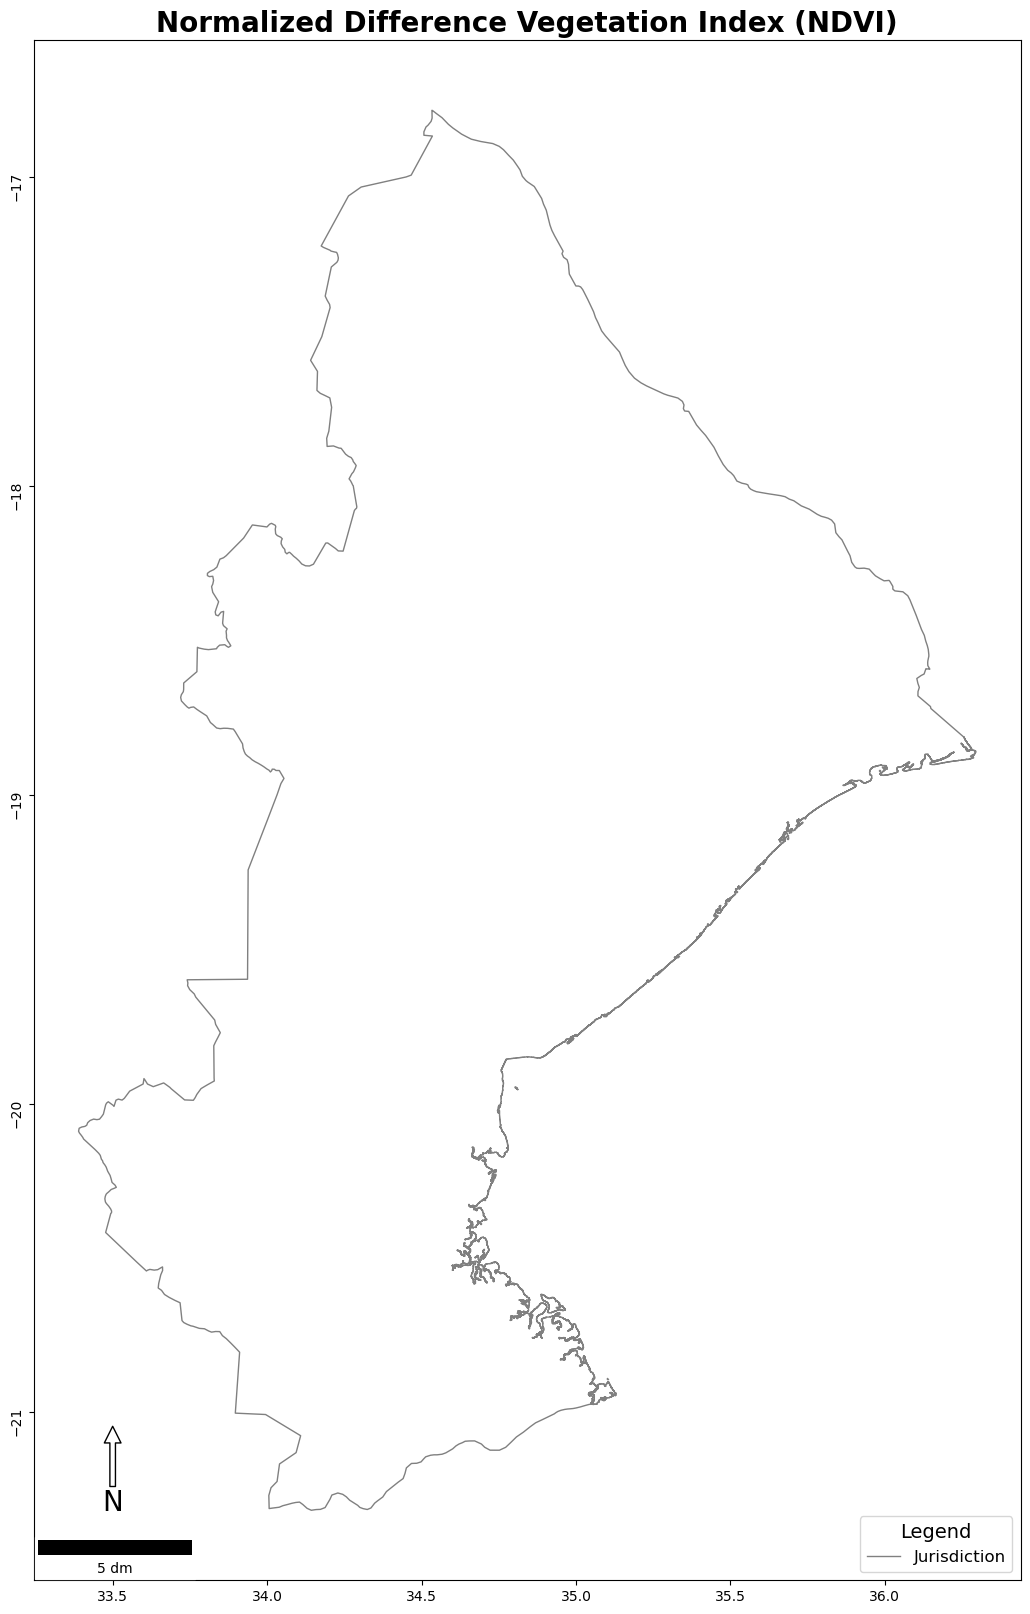

In [111]:
fig_pop, ax_indices = plt.subplots(figsize = (20,20))

# add north arrow
x, y, arrow_length = 0.08, 0.1, 0.05
ax_indices.annotate('N', color='white', xy=(x, y), xytext=(x, y-arrow_length), arrowprops=dict(facecolor='white', width=4, headwidth=12),
                     ha='center', va='center', fontsize=20,
                     xycoords=ax_indices.transAxes)

# add legend
legend_elements = [Line2D([0], [0], color='Grey', lw=1, label='Jurisdiction')]

legend_roi = ax_indices.legend(handles=legend_elements,facecolor="white", prop={'size': 12}, loc='lower right', title = "Legend")
plt.setp(legend_roi.get_title(),fontsize='14')

# add title
# visualization parameter font size, type and weight
ax_indices.set_title('Normalized Difference Vegetation Index (NDVI)',family='sans-serif',fontweight = 'semibold', fontsize=20)

# add scale bar
ax_indices.add_artist(ScaleBar(1,box_alpha=0.6, location = 'lower left'))

# add roi border
ax_indices = df_roi.plot(figsize=(20, 20), color = None, edgecolor = 'Grey', linewidth = 1, facecolor="none", ax = ax_indices)
plt.yticks(rotation='vertical')

# add raster
basemap = ctx.add_basemap(source=ctx.providers.CartoDB.Positron, crs = jurisdiction.crs.to_string(), ax = ax_indices )


# add colorbar
# divider = make_axes_locatable(ax_indices)
fig_pop.add_colorbar(vis_params=indices_viz_params, cmap='viridis',discrete=False,label="NDVI",orientation='horizontal')
# cax_indices = divider.append_axes("bottom", size="3%", pad=0.1)
# cbar = fig_pop.colorbar(matplotlib.cm.ScalarMappable(norm=norm_pop,cmap=cmap_pop), cax=cax_indices, ax=ax_indices, orientation ='horizontal',
#                 label="Population Density (Population/Ha)")